In [15]:
import os
import sys
from hydra import initialize, compose
import matplotlib.pyplot as plt
import pysiaf
from pysiaf.utils.rotations import attitude
from pprint import pprint
import numpy as np
import webbpsf
import matplotlib.patches as patches
import matplotlib

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input, psf, gs

In [11]:
# Read in the Roman SIAF
rsiaf = pysiaf.Siaf('Roman')
 
# Print information about the WFI01_FULL aperture
wfi01 = rsiaf['WFI01_FULL']
print(f'WFI01 Xsci Ref: {wfi01.XSciRef}')
print(f'WFI01 Ysci Ref: {wfi01.YSciRef}')
print(f'WFI01 V2 Ref: {wfi01.V2Ref}')
print(f'WFI01 V3 Ref: {wfi01.V3Ref}')

WFI01 Xsci Ref: 2044.5
WFI01 Ysci Ref: 2044.5
WFI01 V2 Ref: 1312.9491452484797
WFI01 V3 Ref: -1040.7853726755036


In [12]:
# Plot the Roman apertures on the telescope ("V") frame
aperture_labels = [f'WFI{i + 1:02}_FULL' for i in range(18)]
roman_apertures = [rsiaf[rap] for rap in aperture_labels]
# roman_apertures.append('CGI_CEN')

labels = [f'SCA{str(i + 1).zfill(2)}' for i in range(18)]

In [19]:
band = 'F184'
oversample = 5

positions = [(4, 4092), (4, 4092), (2048, 2048), (1024, 3072), (3072, 1024)]
detectors = [4, 17, 1, 7, 15]

save_dir = os.path.join(data_dir, 'output', 'pysaif')
util.create_directory_if_not_exists(save_dir)
kernel_save = os.path.join(save_dir, 'kernels.npy')
if not os.path.exists(kernel_save):
    kernels = [psf.get_psf_kernel(band, det, pos, oversample=oversample) for det, pos in zip(detectors, positions)]
    np.save(kernel_save, kernels)
else:
    print('Loading cached PSF kernels')
    kernels = np.load(kernel_save, allow_pickle=True)

Attempted to get aberrations at field point (4, 4092) which is outside the range of the reference data; approximating to nearest interpolated point (14.007591856223632, 4092.0024510389067)
Attempted to get aberrations at field point (4, 4092) which is outside the range of the reference data; approximating to nearest interpolated point (14.007591856223632, 4092.0024510389067)
Attempted to get aberrations at field point (4, 4092) which is outside the range of the reference data; approximating to nearest interpolated point (14.007591856223632, 4092.0024510389067)
Attempted to get aberrations at field point (4, 4092) which is outside the range of the reference data; approximating to nearest interpolated point (14.007591856223632, 4092.0024510389067)
Attempted to get aberrations at field point (4, 4092) which is outside the range of the reference data; approximating to nearest interpolated point (14.007591856223632, 4092.0024510389067)
Attempted to get aberrations at field point (4, 4092) w

In [51]:
residuals = [kernels[0] - i for i in kernels[1:]]
images = [kernels[0]] + residuals

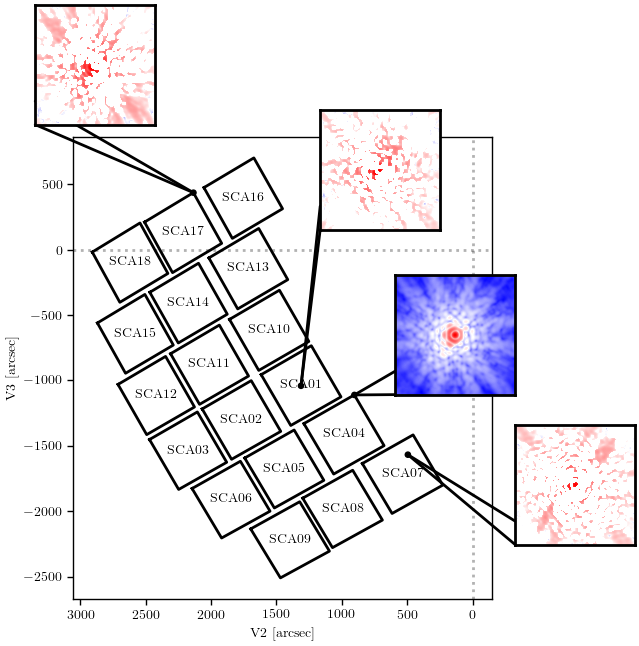

In [57]:
f, ax = plt.subplots(figsize=(7, 7))
 
for i, ap in enumerate(roman_apertures):
    ap.plot(frame='tel', label=False, units='arcsec', color='black')

    # label centers
    v2_ref = ap.V2Ref
    v3_ref = ap.V3Ref
    ax.text(v2_ref, v3_ref, labels[i], ha='center', va='center')

    # mark corners
    # x_list, y_list = ap.corners('tel')
    # coords = [(x, y) for x, y in zip(x_list, y_list)]
    # for c in coords:
        # ax.plot(c[0], c[1], marker='o', color='g')

# mark PSF locations
marker_and_line_color = 'black'
inset_locations = [[0.7,0.45,0.2,0.2], [0.1,0.9,0.2,0.2], [0.575,0.725,0.2,0.2], [0.9,0.2,0.2,0.2]]
patch_locations = [((0,0), (0, 44)), ((0,0), (0, 44)), ((0,0), (0, 44)), ((0,0), (0, 44))]

for det, pos, image, inset_location, patch_location in zip(detectors, positions, images, inset_locations, patch_locations):
    v2, v3 = roman_apertures[det - 1].convert(*pos, from_frame='sci', to_frame='tel')
    circ_coords = (v2, v3)
    circ = patches.Circle(circ_coords, radius=20, color=marker_and_line_color)
    _ = ax.add_patch(circ)
    ax_inset = f.add_axes(inset_location, anchor='NE', zorder=1)
    ax_inset.imshow(np.log10(image), cmap='bwr')
    ax_inset.spines[:].set_linewidth(2.)
    ax_inset.spines[:].set_color(marker_and_line_color)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    con_b = patches.ConnectionPatch(xyA=patch_location[0], coordsA=ax_inset.transData, xyB=circ_coords, coordsB=ax.transData, linewidth=2, color=marker_and_line_color)
    con_t = patches.ConnectionPatch(xyA=patch_location[1], coordsA=ax_inset.transData, xyB=circ_coords, coordsB=ax.transData, linewidth=2, color=marker_and_line_color)
    ax.add_artist(con_b)
    ax.add_artist(con_t)

 
# Add guide lines for boresight (V2, V3) = (0, 0)
ax.axvline(0, color='black', linestyle=':', alpha=0.3)
ax.axhline(0, color='black', linestyle=':', alpha=0.3)
 
# invert the X-axis such that V2 is positive to the left
ax.invert_xaxis()

ax.set_xlabel('V2 [arcsec]')
ax.set_ylabel('V3 [arcsec]')

plt.savefig(os.path.join(figure_dir, 'psfs_across_focal_plane.png'))
plt.show()